In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import bemcs


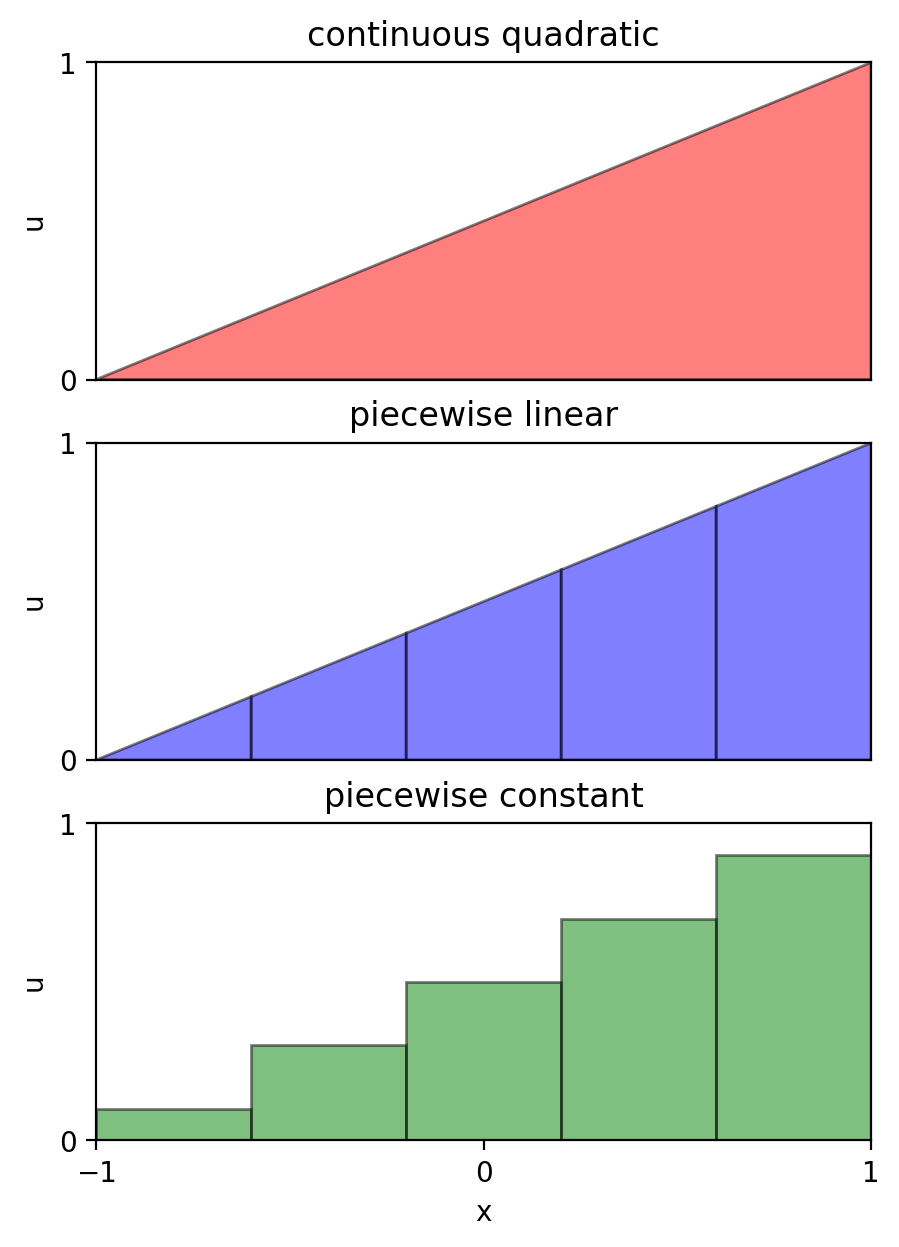

In [13]:
n_pts_high_resolution = 1000
n_pts_low_resolution = 6
n_elements = n_pts_low_resolution - 1
x_high_resolution = np.linspace(-1, 1, n_pts_high_resolution)
x_low_resolution = np.linspace(-1, 1, n_pts_low_resolution)

# Define a quadratic
y_true_high_resolution = 0.5 * x_high_resolution + 0.5
y_true_low_resolution = 0.5 * x_low_resolution + 0.5

# Define a piecweise linear approximation to quadratic
linear_x1 = np.zeros(n_elements)
linear_x2 = np.zeros(n_elements)
linear_y1 = np.zeros(n_elements)
linear_y2 = np.zeros(n_elements)
for i in range(n_elements):
    linear_x1[i] = x_low_resolution[i]
    linear_x2[i] = x_low_resolution[i + 1]
    linear_y1[i] = y_true_low_resolution[i]
    linear_y2[i] = y_true_low_resolution[i + 1]

# Define a piecewise constant apprximation to quadratic
constant_x1 = np.zeros(n_elements)
constant_x2 = np.zeros(n_elements)
constant_y1 = np.zeros(n_elements)
constant_y2 = np.zeros(n_elements)
for i in range(n_elements):
    constant_x1[i] = x_low_resolution[i]
    constant_x2[i] = x_low_resolution[i + 1]
    constant_y1[i] = 0.5 * (y_true_low_resolution[i] + y_true_low_resolution[i + 1])
    constant_y2[i] = 0.5 * (y_true_low_resolution[i] + y_true_low_resolution[i + 1])

# Plot nearly continuous vs. piecewise linear and piecwise constant
plt.figure(figsize=(5, 7))

# High-resolution quadratic
plt.subplot(3, 1, 1)
plt.fill(
    np.append(x_high_resolution, [x_high_resolution[-1], x_high_resolution[0]]),
    np.append(y_true_high_resolution, [0, 0]),
    "-r",
    alpha=0.5,
    edgecolor="k",
    label="quadratic",
)
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("continuous quadratic")

# Linear slip elements
plt.subplot(3, 1, 2)
for i in range(n_elements):
    if i == 0:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
            label="piecewise linear",
        )
    else:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
        )

plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("piecewise linear")

# Constant slip elements
plt.subplot(3, 1, 3)
for i in range(n_elements):
    if i == 0:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
            label="piecewise constant",
        )
    else:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
        )
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([-1, 0, 1])
plt.yticks([0, 1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("piecewise constant")
plt.show()


# Define geometry of single element model

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:143: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(


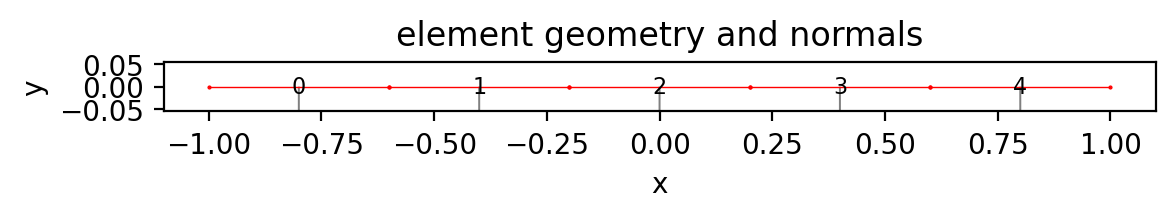

In [14]:
# List of elements for forward model
mu = np.array([3e10])
nu = np.array([0.25])
elements = []
element = {}
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_elements)

for i in range(0, x1.size):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)
bemcs.plot_element_geometry(elements)


# Observation coordinates

In [15]:
n_pts = 100
width = 2
x_obs = np.linspace(-width, width, n_pts)
y_obs = np.linspace(-width, width, n_pts)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()


# Approximation with constant slip elements

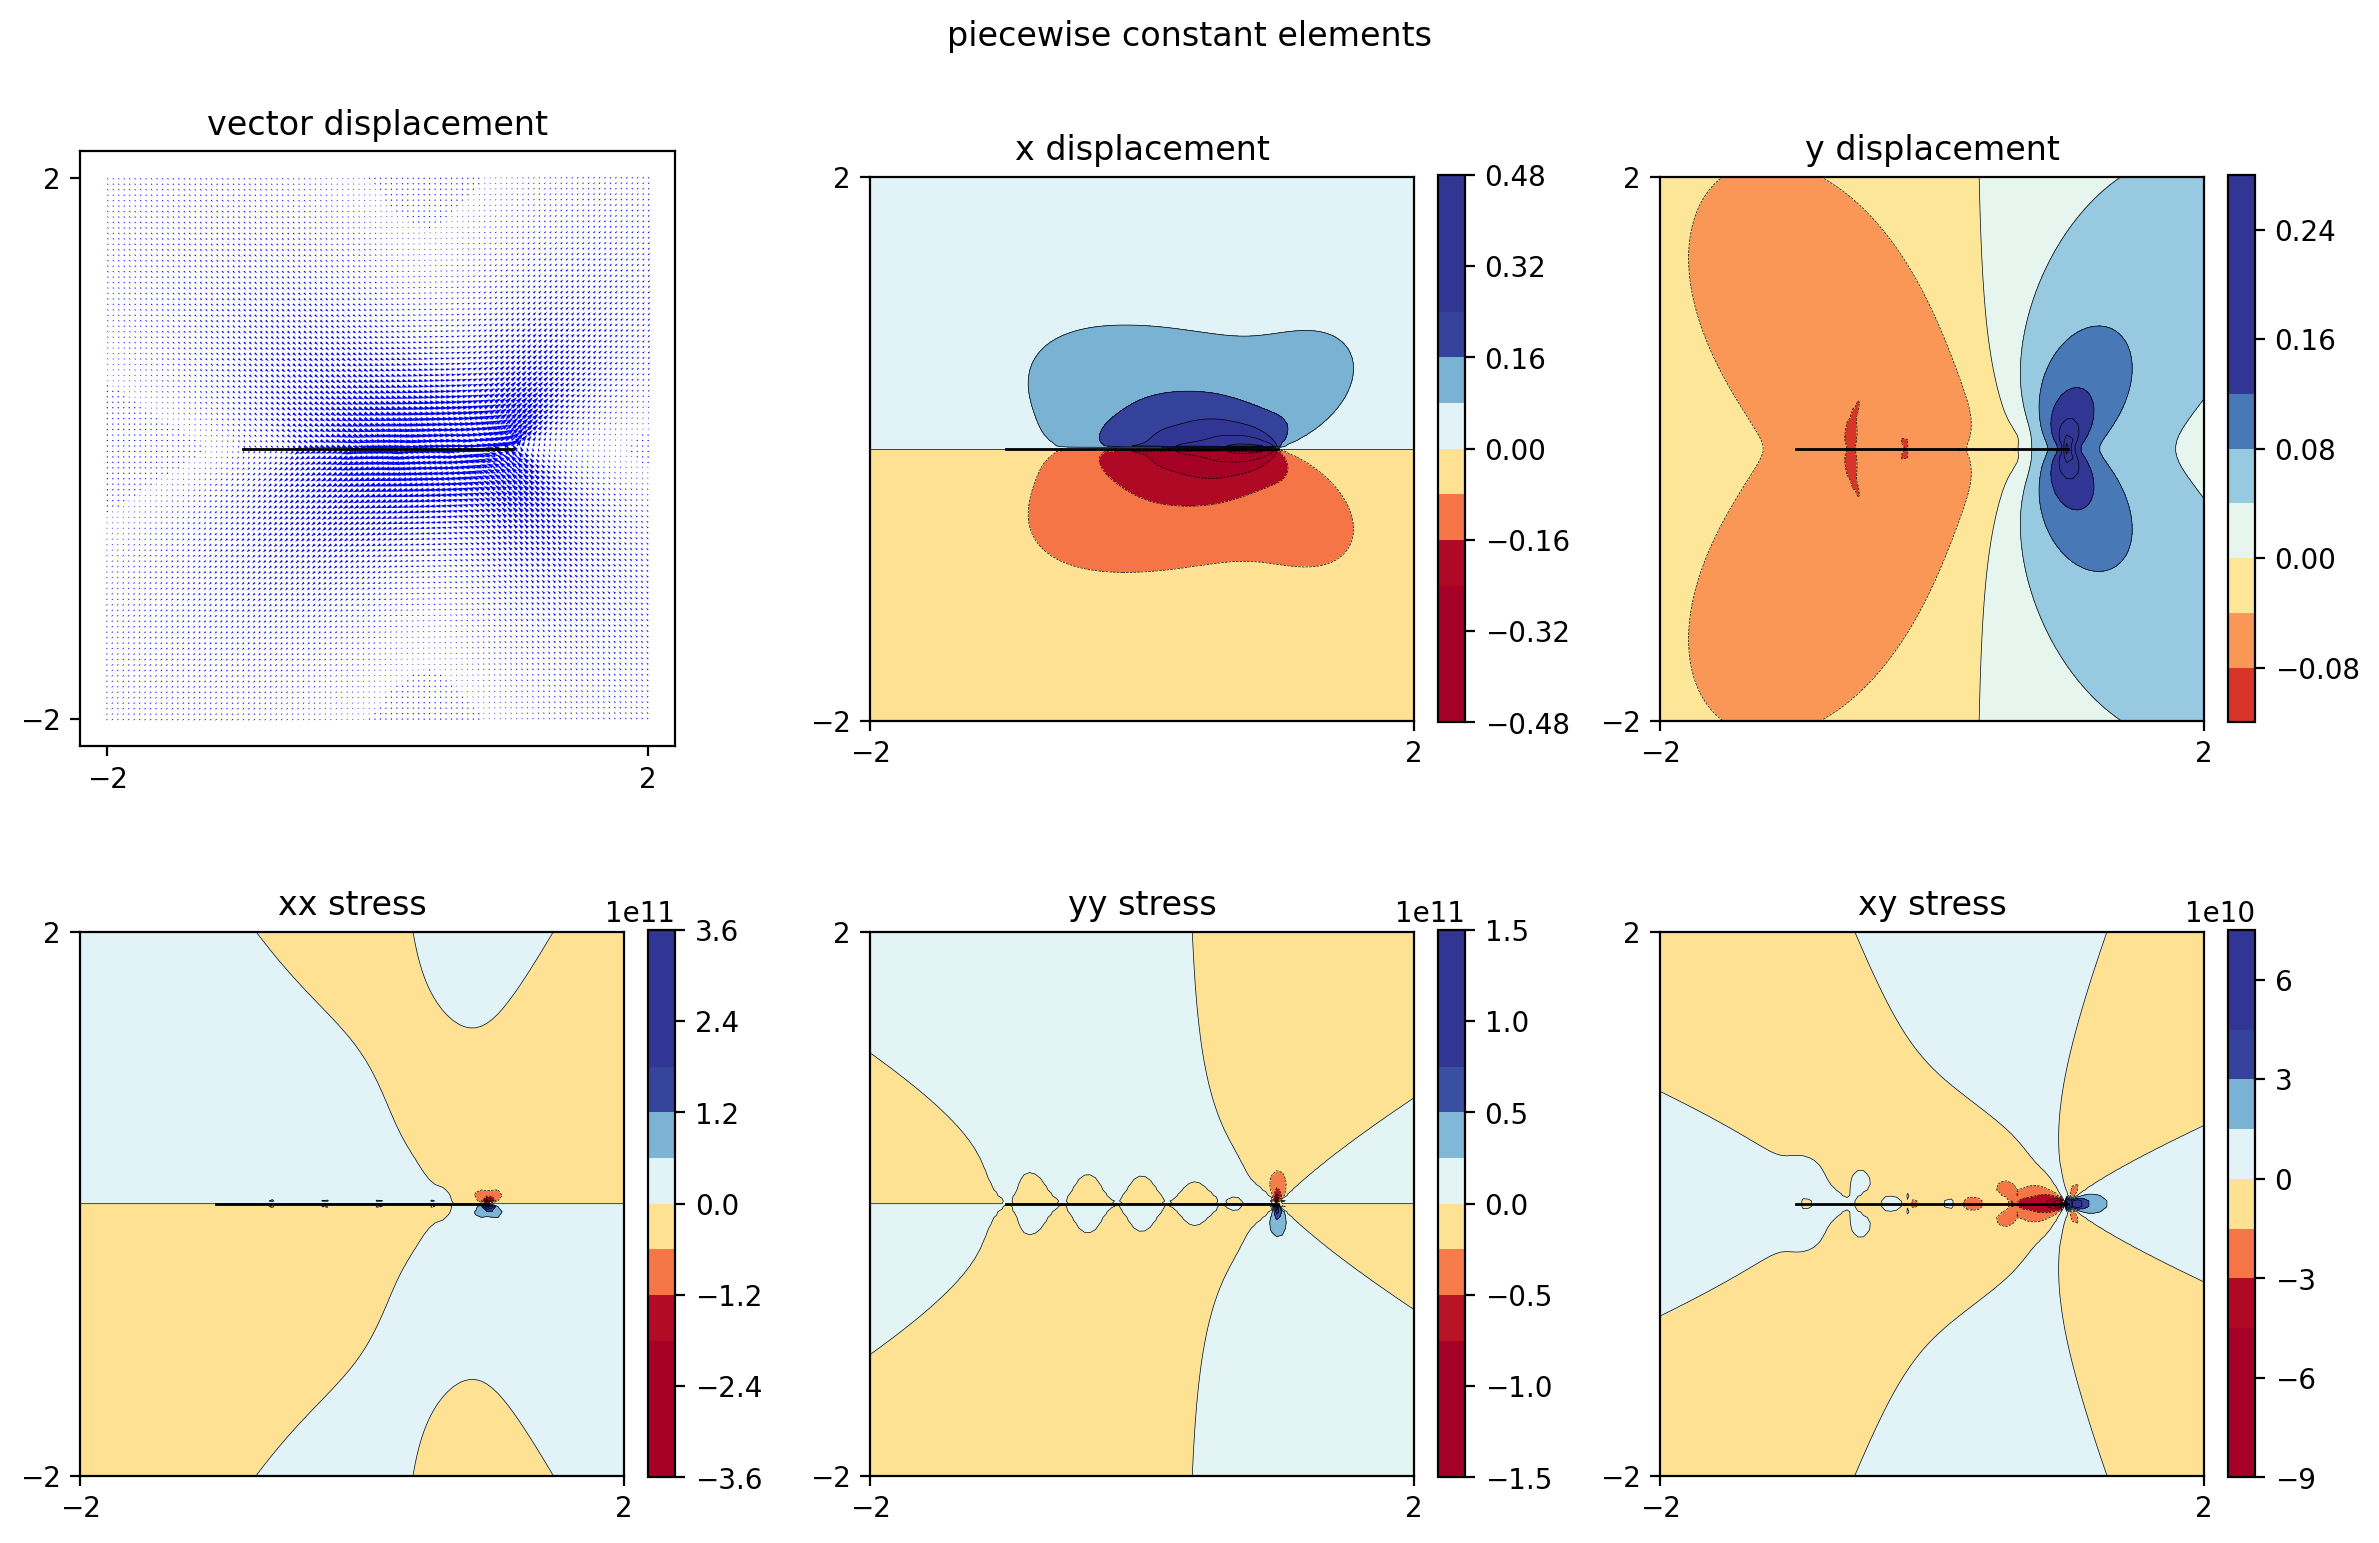

In [16]:
strike_slip_constant = np.copy(constant_y1)
tensile_slip_constant = 0

displacement_constant_total = np.zeros((2, len(x_obs)))
stress_constant_total = np.zeros((3, len(x_obs)))

for i in range(len(elements)):
    (
        displacement_constant,
        stress_constant,
    ) = bemcs.displacements_stresses_constant_no_rotation(
        x_obs,
        y_obs,
        elements[i]["half_length"],
        mu,
        nu,
        strike_slip_constant[i],
        tensile_slip_constant,
        elements[i]["x_center"],
        elements[i]["y_center"],
    )
    displacement_constant_total += displacement_constant
    stress_constant_total += stress_constant

bemcs.plot_fields(
    elements,
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    displacement_constant_total,
    stress_constant_total,
    "piecewise constant elements",
)


# Approximation with linear slip elements

i=0
end_displacement_1=0.000, end_displacement_2=0.200
strike_slip_linear=array([0.6, 0.7, 0.8])
i=1
end_displacement_1=0.200, end_displacement_2=0.400
strike_slip_linear=array([0.5, 0.6, 0.7])
i=2
end_displacement_1=0.400, end_displacement_2=0.600
strike_slip_linear=array([0.4, 0.5, 0.6])
i=3
end_displacement_1=0.600, end_displacement_2=0.800
strike_slip_linear=array([0.3, 0.4, 0.5])
i=4
end_displacement_1=0.800, end_displacement_2=1.000
strike_slip_linear=array([0.2, 0.3, 0.4])


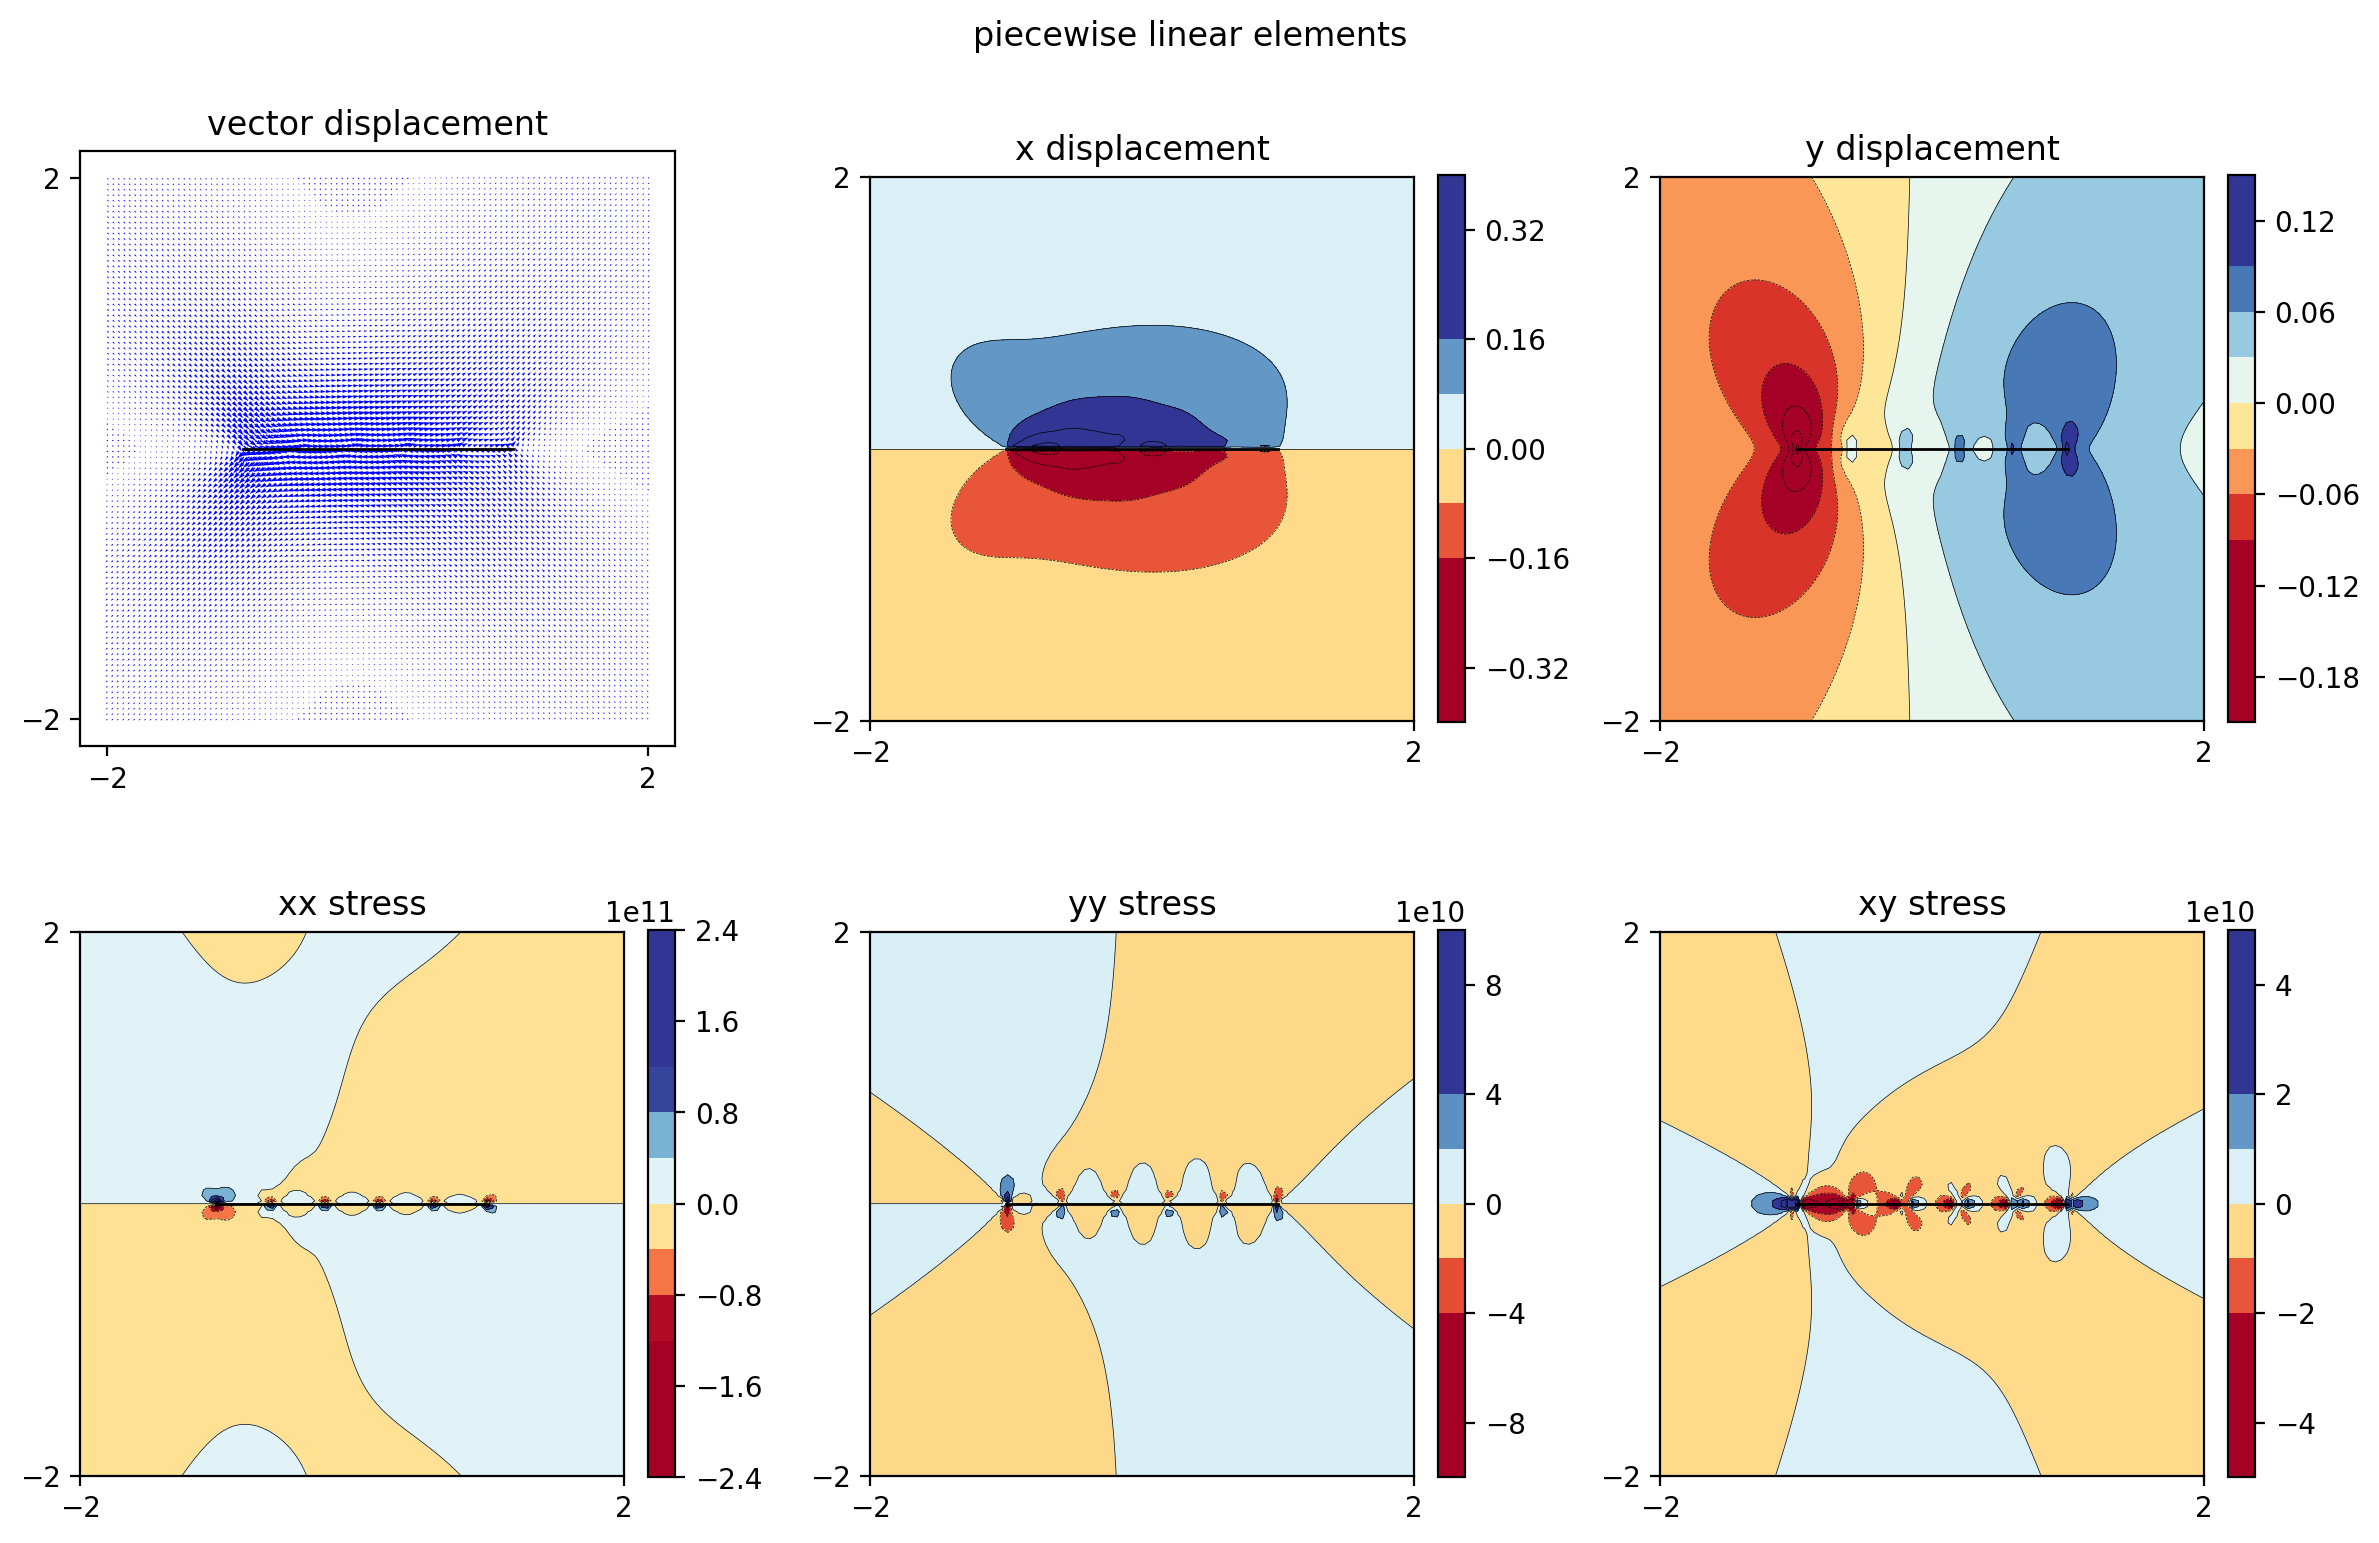

In [17]:
displacement_linear_total = np.zeros((2, len(x_obs)))
stress_linear_total = np.zeros((3, len(x_obs)))

for i in range(len(elements)):
    print(f"{i=}")

    # Calculate quadratic weights for linear slip
    node_coordinates = elements[i]["x_integration_points"]
    element_half_length = elements[i]["half_length"]
    end_displacement_1 = linear_y1[i]
    end_displacement_2 = linear_y2[i]
    print(f"{end_displacement_1=:0.3f}, {end_displacement_2=:0.3f}")

    quadratic_coefficients = bemcs.get_quadratic_coefficients_for_linear_slip(
        element_half_length, node_coordinates, end_displacement_1, end_displacement_2
    )
    strike_slip_linear = np.copy(quadratic_coefficients)
    print(f"{strike_slip_linear=}")
    tensile_slip_linear = [0.0, 0.0, 0.0]

    # Calculate displacements and stresses for current element
    (
        displacement_linear,
        stress_linear,
    ) = bemcs.displacements_stresses_quadratic_no_rotation(
        x_obs,
        y_obs,
        elements[i]["half_length"],
        mu,
        nu,
        strike_slip_linear,
        tensile_slip_linear,
        elements[i]["x_center"],
        elements[i]["y_center"],
    )

    # Add current element contribution to total
    displacement_linear_total += displacement_linear
    stress_linear_total += stress_linear

bemcs.plot_fields(
    elements,
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    displacement_linear_total,
    stress_linear_total,
    "piecewise linear elements",
)


# Single quadratic slip element (THIS IS CURRENTLY INCORRECT)

end_displacement_1=0.000, end_displacement_2=1.000
quadratic_coefficients=array([0. , 0.5, 1. ])
strike_slip_linear=array([0. , 0.5, 1. ])


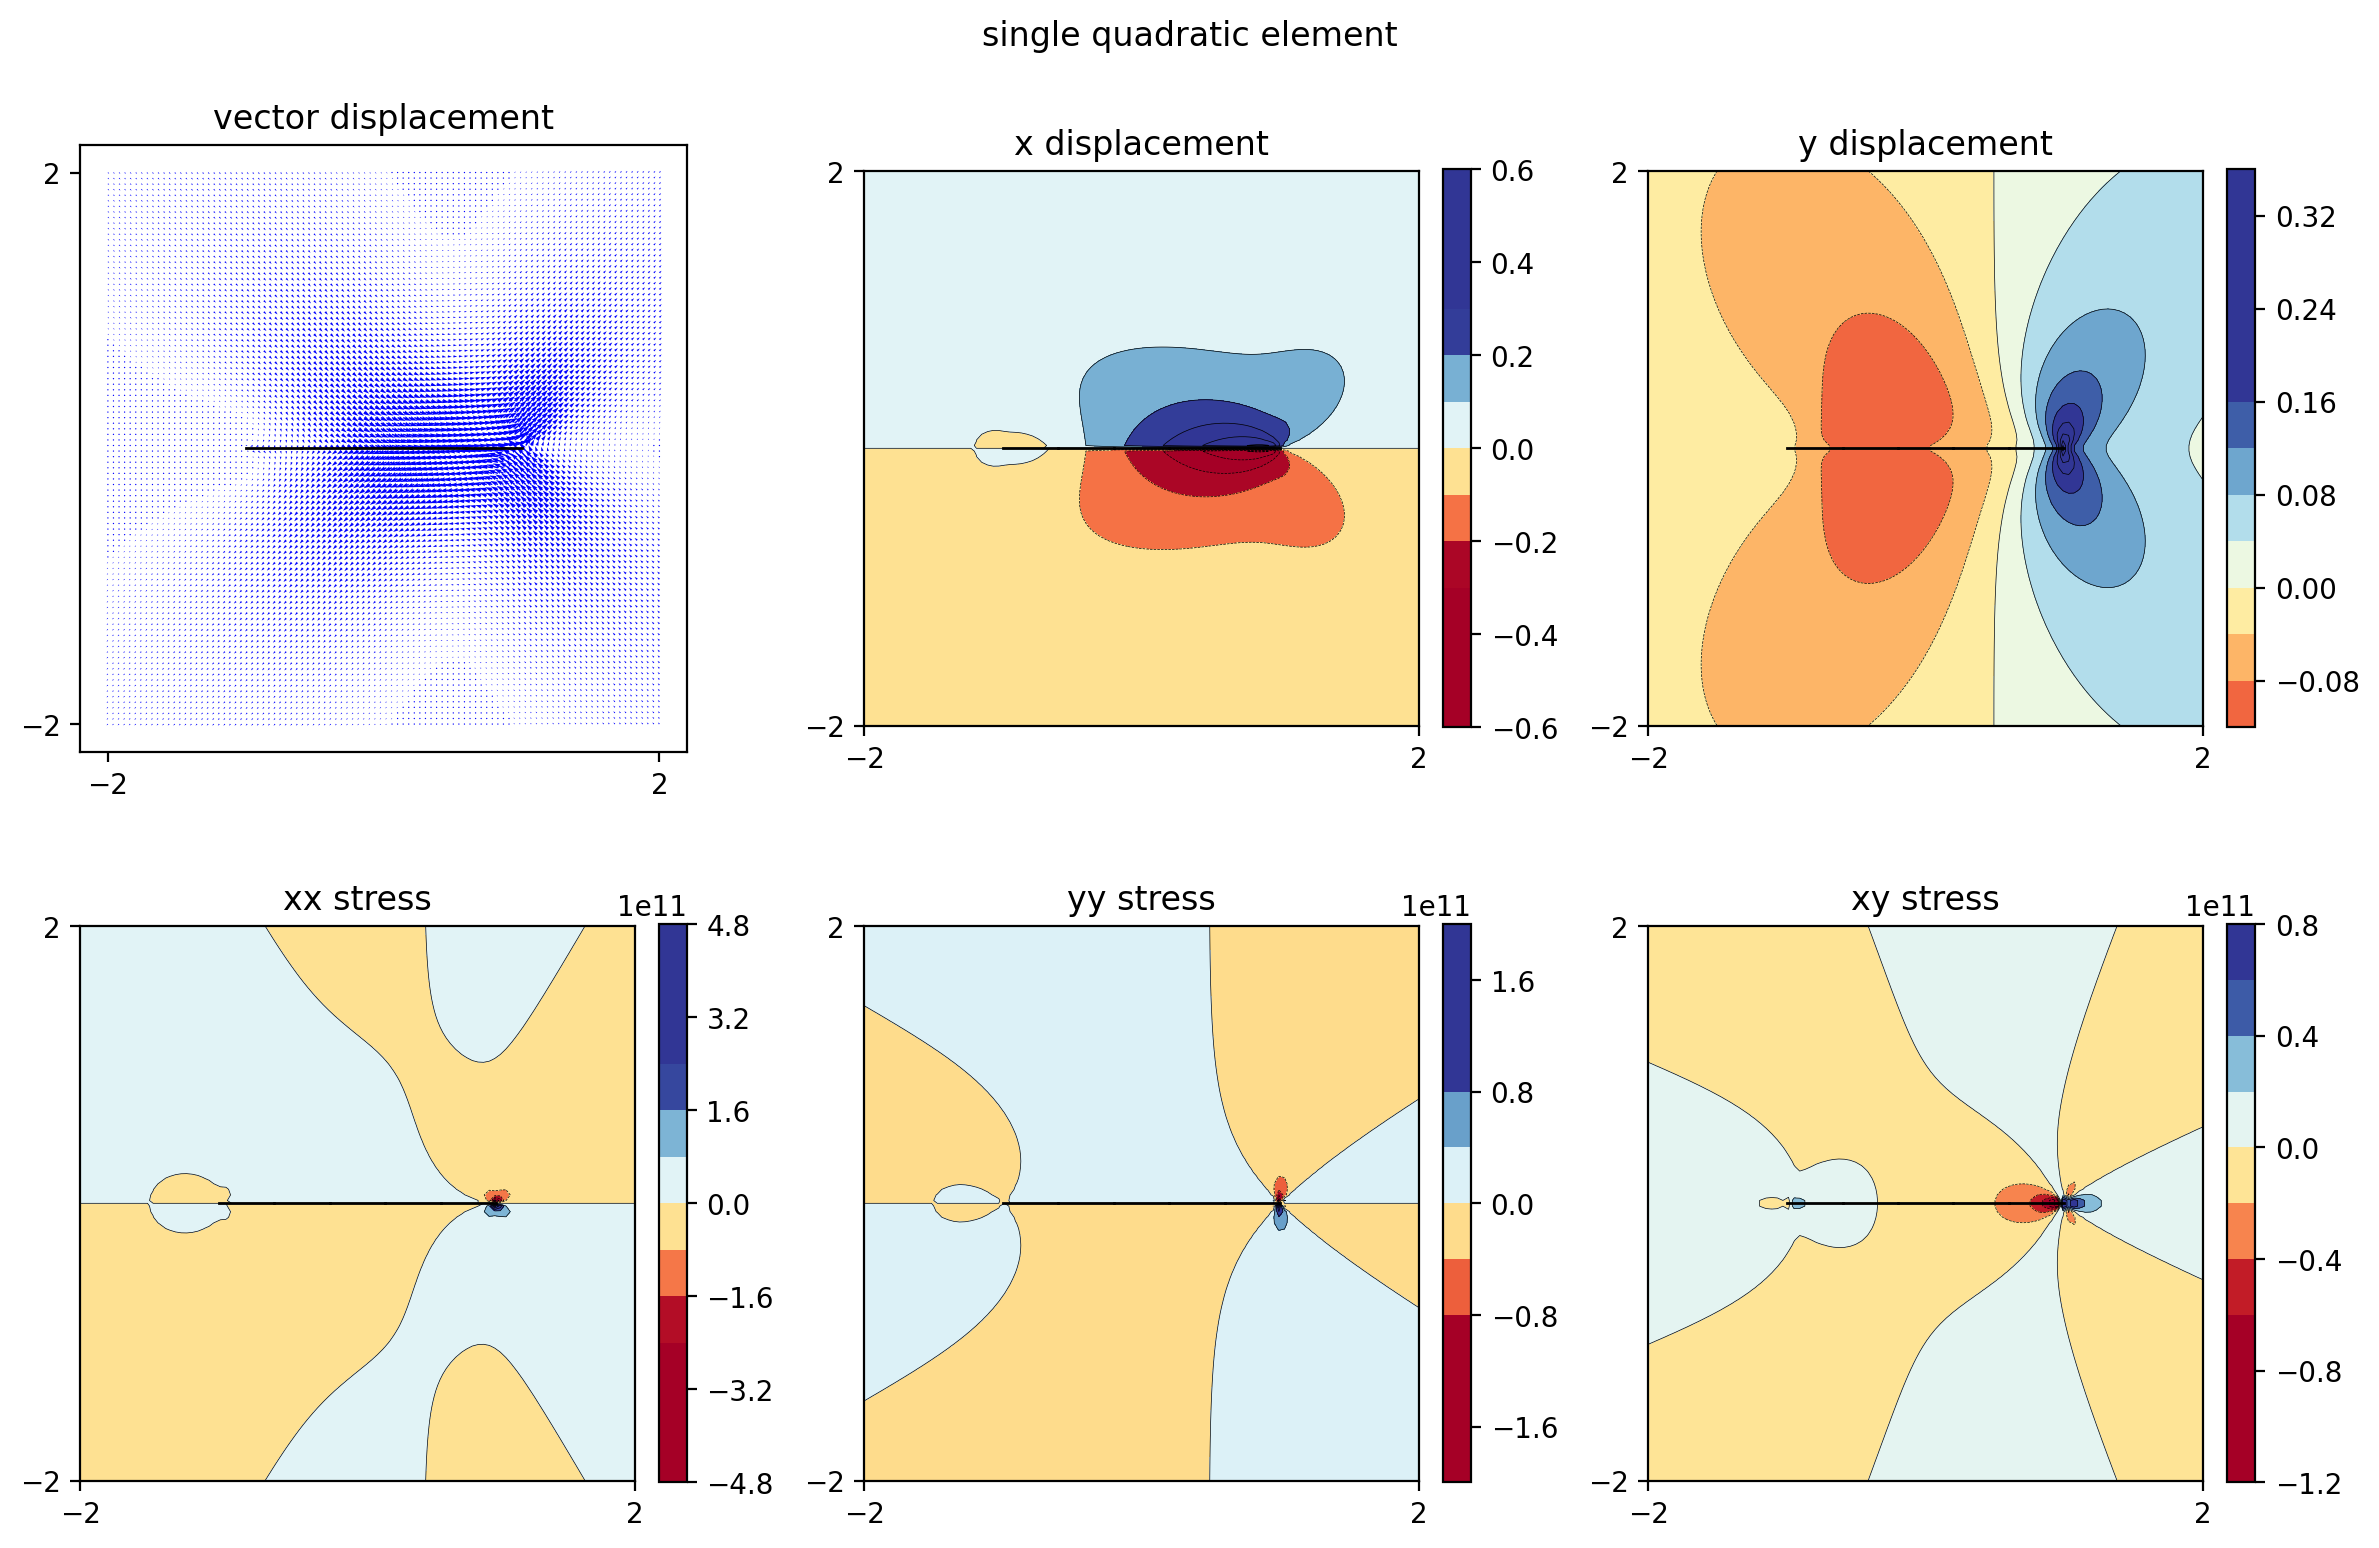

In [20]:
elements_single = []
element = {}
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, 1)

for i in range(0, x1.size):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements_single.append(element.copy())
elements_single = bemcs.standardize_elements(elements_single)


node_coordinates = elements_single[0]["x_integration_points"]
element_half_length = elements_single[0]["half_length"]
end_displacement_1 = 0.0
end_displacement_2 = 1.0
print(f"{end_displacement_1=:0.3f}, {end_displacement_2=:0.3f}")

quadratic_coefficients = bemcs.get_quadratic_coefficients_for_linear_slip(
    element_half_length, node_coordinates, end_displacement_1, end_displacement_2
)

print(f"{quadratic_coefficients=}")
strike_slip_linear = np.copy(quadratic_coefficients)
print(f"{strike_slip_linear=}")
tensile_slip_linear = [0.0, 0.0, 0.0]

(
    displacement_quadratic,
    stress_quadratic,
) = bemcs.displacements_stresses_quadratic_no_rotation(
    x_obs,
    y_obs,
    elements_single[0]["half_length"],
    mu,
    nu,
    strike_slip_linear,
    tensile_slip_linear,
    elements_single[0]["x_center"],
    elements_single[0]["y_center"],
)

bemcs.plot_fields(
    elements,
    x_obs.reshape(n_pts, n_pts),
    y_obs.reshape(n_pts, n_pts),
    displacement_quadratic,
    stress_quadratic,
    "single quadratic element",
)
